In [129]:
%matplotlib inline

In [2]:
import os
import urllib
import pandas as pd
import random
from statsmodels.robust import scale
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns

In [259]:
random.seed(123)

In [248]:
# We're going to be building a 'TP53' logistic regression classifier with
# an elastic net penalty
GENE = 'TP53'
CLASSIFIER = 'log'
PENALTY = 'elasticnet'

In [231]:
# Parameter Sweep for Hyperparameters
alpha_params = [0.05, 0.1, 0.2, 0.3]
l1_params = [0.05, 0.1, 0.2, 0.3]

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

# Load Data

In [3]:
if not os.path.exists('data'):
    os.makedirs('data')

In [5]:
# Download X Matrix
url = 'https://ndownloader.figshare.com/files/5514386'
if not os.path.exists('data/expression.tsv.bz2'):
    urllib.request.urlretrieve(url, os.path.join('data', 'expression.tsv.bz2'))

In [230]:
X = pd.read_table(os.path.join('data', 'expression.tsv.bz2'), index_col=0)

In [7]:
# Download Y Matrix
url = "https://ndownloader.figshare.com/files/5514389"
if not os.path.exists('data/mutation-matrix.tsv.bz2'):
    urllib.request.urlretrieve(url, os.path.join('data', 'mutation-matrix.tsv.bz2'))

In [220]:
Y = pd.read_table(os.path.join('data', 'mutation-matrix.tsv.bz2'), index_col=0)

# Process Mutation Matrix

In [223]:
Y_p53 = pd.Series(Y['TP53'], index=Y.index)

In [227]:
# The Series now holds TP53 Mutation Status for each Sample
Y_p53.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: TP53, dtype: int64

In [226]:
Y_p53.value_counts(True)

0    0.655334
1    0.344666
Name: TP53, dtype: float64

# Process X Matrix

In [234]:
# Subset X matrix to only 5,000 highest MAD (median absolute deviation) genes
all_mad_genes = scale.mad(X, c=1, axis=0)
all_mad_genes = pd.Series(all_mad_genes,
                          index=X.columns.values)
all_mad_genes = all_mad_genes.sort_values(ascending=False)

In [260]:
X_sub = X[all_mad_genes.index[:5000]]

In [238]:
# Normalize X matrix by Z-scoring genes
X_matrix_scale = preprocessing.scale(X_sub)
X_matrix_sub = pd.DataFrame(X_matrix_scale, index=X_sub.index, columns=X_sub.columns)

# Hold Out 10% of the data

In [245]:
X_matrix, X_holdout, Y_matrix, Y_holdout = train_test_split(
    X_matrix_sub, Y_p53, test_size=0.1, random_state=123)

# Cross Validation to select Hyperparameters

In [261]:
# 5 fold cross validation ensuring balanced status membership
cv_accuracy = []
skf = StratifiedKFold(Y_matrix, 5, random_state=123)
for train_idx, test_idx in skf:
    X_train, X_test = X_matrix.ix[train_idx], X_matrix.ix[test_idx]
    Y_train, Y_test = Y_matrix.ix[train_idx], Y_matrix.ix[test_idx]
    for alpha_param in alpha_params:
        for l1_param in l1_params:
            
            # Initialize logistic regression classifier
            clf = SGDClassifier(loss=CLASSIFIER,
                    penalty=PENALTY,
                    alpha=alpha_param,
                    l1_ratio=l1_param,
                    class_weight='balanced',
                    random_state=123)
            
            # Fit the model
            clf.fit(X_train, Y_train)
            predict_y_train = clf.predict(X_train)
            predict_y_test = clf.predict(X_test)
            
            # Get the train/test AUROC balanced by class
            train_error = roc_auc_score(Y_train, predict_y_train, average='weighted')
            test_error = roc_auc_score(Y_test, predict_y_test, average='weighted')
            
            # Obtain metrics for plotting
            cv_accuracy.append(['train', train_error, alpha_param, l1_param])
            cv_accuracy.append(['test', test_error, alpha_param, l1_param])

# Plot Performance to Select Hyperparameters

In [262]:
plot_ready = pd.DataFrame(cv_accuracy, columns=['type', 'AUROC', 'alpha', 'l1'])

In [263]:
plot_ready.head(5)

,type,AUROC,alpha,l1
0,train,0.903032,0.05,0.05
1,test,0.860971,0.05,0.05
2,train,0.888364,0.05,0.10
3,test,0.858065,0.05,0.10
4,train,0.874179,0.05,0.20


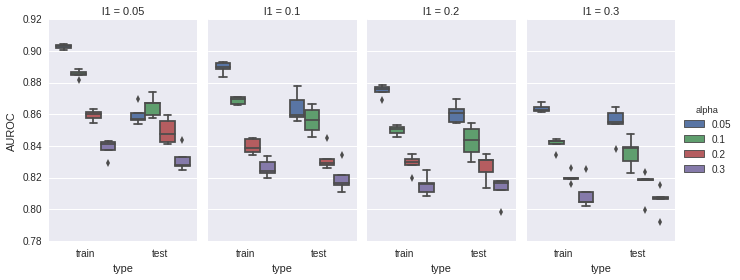

In [264]:
sns.factorplot(x="type", y="AUROC", hue="alpha",
               col="l1", data=plot_ready, kind="box", size=4, aspect=0.6);

# Use Optimal Hyperparameters to Output ROC Curve

In [265]:
# Select optimal hyperparameters based on performance in test-set
optimal_alpha = 0.05
optimal_l1 = 0.1

# Initialize optimal classifier
clf = SGDClassifier(loss=CLASSIFIER,
                    penalty=PENALTY,
                    alpha=optimal_alpha,
                    l1_ratio=optimal_l1,
                    class_weight='balanced',
                    random_state=1234)

# Fit the classifier using the training data and predict the hold out set
clf.fit(X_sub, Y_p53)
y_score = clf.decision_function(X_sub)
y_score_hold = clf.decision_function(X_holdout)

# Get True/False Positive Rates
fpr, tpr, _ = roc_curve(Y_p53, y_score)
fpr_hold, tpr_hold, _ = roc_curve(Y_holdout, y_score_hold)

# Get AUROC
train_error = roc_auc_score(Y_p53, y_score, average='weighted')
holdout_error = roc_auc_score(Y_holdout, y_score_hold, average='weighted')

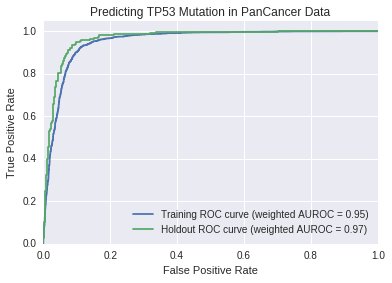

In [266]:
# Plot ROC
plt.figure()
plt.plot(fpr, tpr, label='Training ROC curve (weighted AUROC = {0:0.2f})'.format(train_error))
plt.plot(fpr_hold, tpr_hold, label='Holdout ROC curve (weighted AUROC = {0:0.2f})'.format(holdout_error))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 Mutation in PanCancer Data')
plt.legend(loc='lower right')

It looks like the holdout set actually performed BETTER by chance

# What is the classifier?

In [267]:
classifier = pd.DataFrame(clf.coef_.T, index=X_matrix.columns, columns=['weight'])
classifier['abs'] = classifier['weight'].abs()
classifier = classifier.sort_values('abs', ascending=False)

In [268]:
classifier.head(10)

,weight,abs
EDA2R,-1.599357,1.599357
SPATA18,-1.160264,1.160264
C6orf138,-1.120526,1.120526
GDF15,-0.687113,0.687113
CDKN2A,0.647423,0.647423
TNFRSF10C,-0.612451,0.612451
HSPA4L,-0.423845,0.423845
PANX2,0.414740,0.414740
GPR172B,-0.401407,0.401407
HES2,-0.400926,0.400926


The results are not surprising. TP53 is a transcription modulator and when it mutated in a tumor, the cell goes haywire. Also, the genes that the classifier uses is interesting, but not necessarily novel.

1. TP53 is a [transcription factor](https://en.wikipedia.org/wiki/Transcription_factor "TF wiki") that regulates many genes including EDA2R. Studies have linked EDA2R (or XEDAR) to [increased survival in colon cancer patients](http://www.ncbi.nlm.nih.gov/pubmed/19543321) and [losing hair as a result of chemotherapy](http://onlinelibrary.wiley.com/doi/10.1016/j.febslet.2010.04.058/full)
2. SPATA18 is a gene associated with spermatogenesis and is a transcription factor for TP53. It's association with TP53 was [recently discovered](http://www.ncbi.nlm.nih.gov/pubmed/21300779) in 2011.
3. C6orf138 (or [PTCHD4](http://www.genecards.org/cgi-bin/carddisp.pl?gene=PTCHD4)) is also a transcriptional target for TP53 and was only recently discovered in [2014 to repress hedgehog signalling](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC4239647/).
4. The list goes on and includes several other TP53 targets...